# **Strategic Analysis of E-Commerce Conversion Anomalies**

Objective: To identify the root causes of cart abandonment and the ~95% drop-off rate observed in the checkout funnel. This analysis systematically tests user behavior, pricing, logistics, and technical factors to pinpoint the bottleneck.

Project Context

Dataset: Historical e-commerce sales and event data.

Time Period: January 2020 – May 2025.

Scope: The dataset includes user demographics, web traffic events, order details, and product information.

Goal: To analyze the user journey and conversion funnel to understand why ~95% of users who add items to their cart fail to complete a purchase.

**1. Data Preparation & Initial Exploration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
#Load the multi-file data
df_customers = pd.read_csv('customers.csv')
df_events = pd.read_csv('events.csv')
df_orders = pd.read_csv('orders.csv')
df_products = pd.read_csv('products.csv')
df_sessions = pd.read_csv('sessions.csv')
df_order_items = pd.read_csv('order_items.csv')
df_reviews = pd.read_csv('reviews.csv')

In [ ]:
df_sessions

,session_id,customer_id,start_time,device,source,country
0,1,12360,2021-12-27T00:01:36,mobile,email,DE
1,2,13917,2025-01-31T21:29:42,desktop,organic,PL
2,3,1022,2024-02-19T00:52:50,tablet,organic,FR
3,4,2882,2024-08-04T19:54:31,mobile,direct,GB
4,5,1286,2022-06-28T13:58:08,desktop,email,ES
...,...,...,...,...,...,...
119995,119996,19822,2024-05-07T18:33:25,mobile,referral,NL
119996,119997,16146,2021-05-01T17:47:49,mobile,organic,AU
119997,119998,18871,2020-08-23T13:20:31,tablet,direct,PL
119998,119999,19550,2025-04-22T09:54:56,mobile,referral,US


In [ ]:
# Check the unique event types to see "clicks"
print(df_events['event_type'].value_counts())

event_type
page_view      539343
add_to_cart    143126
checkout        44909
purchase        33580
Name: count, dtype: int64


In [ ]:
import sqlite3

#Create a connection to an in-memory SQL database
conn = sqlite3.connect(':memory:')

#Load your DataFrames into the SQL database
df_customers.to_sql('customers', conn, index=False, if_exists='replace')
df_events.to_sql('events', conn, index=False, if_exists='replace')
df_orders.to_sql('orders', conn, index=False, if_exists='replace')
df_order_items.to_sql('order_items', conn, index=False, if_exists='replace')
df_products.to_sql('products', conn, index=False, if_exists='replace')
df_sessions.to_sql('sessions', conn, index=False, if_exists='replace')

print("✅ Data successfully loaded into SQL environment!")

✅ Data successfully loaded into SQL environment!


In [ ]:
#function to run SQL queries and return a DataFrame
def run_query(query):
    return pd.read_sql_query(query, conn)

# TEST: Select the first 5 rows from the customers table
test_query = """
SELECT *
FROM customers
LIMIT 5;
"""

run_query(test_query)

,customer_id,name,email,country,age,signup_date,marketing_opt_in
0,1,Jennifer Salinas,nicholas59@example.org,JP,71,2020-09-04,1
1,2,Phillip Ramos,christinarubio@example.com,IN,26,2020-04-05,0
2,3,Dawn Fowler,jessica03@example.org,BR,21,2023-08-31,1
3,4,Mario Butler,paula27@example.org,FR,63,2022-06-30,1
4,5,Amber Brown,kevin85@example.net,BR,19,2022-07-22,1


In [ ]:
# Dictionary of your loaded DataFrames
all_dfs = {
    "Customers": df_customers,
    "Events": df_events,
    "Orders": df_orders,
    "Order_Items": df_order_items,
    "Products": df_products,
    "Sessions": df_sessions
}

# Loop through each dataframe to print Info and Missing Values
for name, df in all_dfs.items():
    print(f"================ {name} ================")
    print(f"Shape: {df.shape} (Rows, Columns)")
    print("-" * 30)
    print("DATA TYPES:")
    print(df.dtypes)
    print("-" * 30)
    print("MISSING VALUES:")
    print(df.isnull().sum()[df.isnull().sum() > 0]) # Only show columns with missing data
    print("\n")

================ Customers ================
Shape: (20000, 7) (Rows, Columns)
------------------------------
DATA TYPES:
customer_id          int64
name                object
email               object
country             object
age                  int64
signup_date         object
marketing_opt_in      bool
dtype: object
------------------------------
MISSING VALUES:
Series([], dtype: int64)


================ Events ================
Shape: (760958, 10) (Rows, Columns)
------------------------------
DATA TYPES:
event_id          int64
session_id        int64
timestamp        object
event_type       object
product_id      float64
qty             float64
cart_size       float64
payment          object
discount_pct    float64
amount_usd      float64
dtype: object
------------------------------
MISSING VALUES:
product_id       78489
qty             617832
cart_size       716049
payment         727378
discount_pct    727378
amount_usd      727378
dtype: int64


================ Orders ====

**2. Conversion Funnel Analysis**

In [ ]:
#Funnel Construction

funnel_query = """
SELECT
    s.device,
    COUNT(DISTINCT s.session_id) AS total_visits,
    COUNT(DISTINCT CASE WHEN e.event_type = 'page_view' THEN s.session_id END) AS product_views,
    COUNT(DISTINCT CASE WHEN e.event_type = 'add_to_cart' THEN s.session_id END) AS add_to_cart,
    COUNT(DISTINCT CASE WHEN e.event_type = 'purchase' THEN s.session_id END) AS purchases
FROM sessions s
LEFT JOIN events e
    ON s.session_id = e.session_id
GROUP BY 1
ORDER BY 2 DESC;
"""

df_funnel = run_query(funnel_query)
df_funnel

,device,total_visits,product_views,add_to_cart,purchases
0,mobile,65942,65942,44800,18469
1,desktop,45547,45547,30990,12750
2,tablet,8511,8511,5728,2361


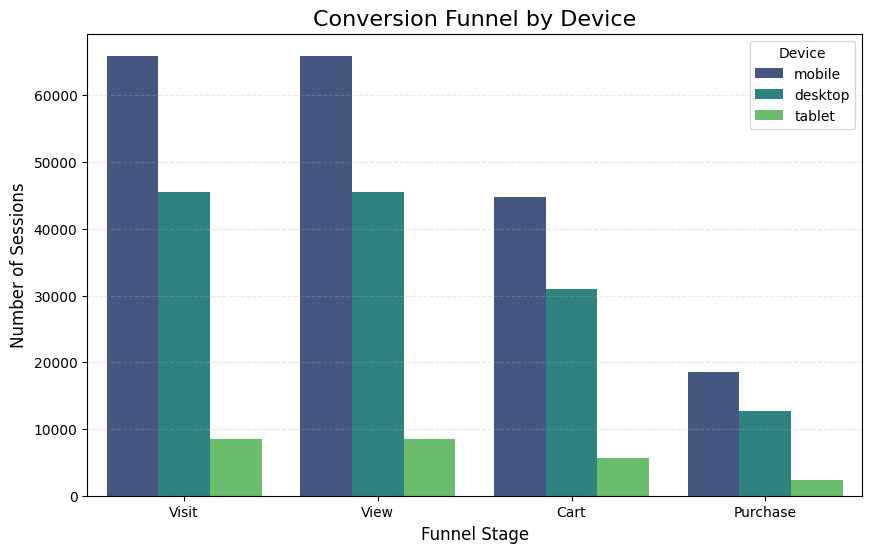

In [ ]:
# Funnel Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe to long format
funnel_long = df_funnel.melt(id_vars='device',
                             var_name='stage',
                             value_name='count')

# Define the correct order for the funnel stages
stage_order = ['total_visits', 'product_views', 'add_to_cart', 'purchases']
funnel_long['stage'] = pd.Categorical(funnel_long['stage'], categories=stage_order, ordered=True)

#Create the grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_long, x='stage', y='count', hue='device', palette='viridis')

plt.title('Conversion Funnel by Device', fontsize=16)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xlabel('Funnel Stage', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Visit', 'View', 'Cart', 'Purchase'])
plt.legend(title='Device')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

# **3. Hypothesis Testing: Why do users abandon the cart?**

In [ ]:
#Testing the Checkout difficulty theory
# join 'events' with 'products' to get the actual price of items added to the cart
price_query_corrected = """
WITH cart_value AS (
    SELECT
        e.session_id,
        MAX(p.price_usd) as max_cart_amount
    FROM events e
    JOIN products p ON e.product_id = p.product_id
    WHERE e.event_type = 'add_to_cart'
    GROUP BY 1
), conversion_status AS (
    SELECT
        s.session_id,
        cv.max_cart_amount,
        CASE WHEN COUNT(e.event_id) > 0 THEN 1 ELSE 0 END as made_purchase
    FROM sessions s
    JOIN cart_value cv ON s.session_id = cv.session_id
    LEFT JOIN events e ON s.session_id = e.session_id AND e.event_type = 'purchase'
    GROUP BY 1, 2
)
SELECT
    CASE
        WHEN max_cart_amount < 50 THEN '1. Low Value (<$50)'
        WHEN max_cart_amount BETWEEN 50 AND 150 THEN '2. Medium Value ($50-$150)'
        WHEN max_cart_amount > 150 THEN '3. High Value (>$150)'
        ELSE 'Unknown'
    END as cart_segment,
    COUNT(session_id) as total_sessions,
    SUM(made_purchase) as total_purchases,
    ROUND(CAST(SUM(made_purchase) AS REAL) / COUNT(session_id), 4) as conversion_rate
FROM conversion_status
GROUP BY 1
ORDER BY 1;
"""

# Run the query using your existing helper function
df_price_test = run_query(price_query_corrected)

# Display the resulting table
print("Conversion Rate by Cart Price Segment:")
display(df_price_test)

Conversion Rate by Cart Price Segment:


,cart_segment,total_sessions,total_purchases,conversion_rate
0,1. Low Value (<$50),33692,13710,0.4069
1,2. Medium Value ($50-$150),36392,15134,0.4159
2,3. High Value (>$150),11434,4736,0.4142


In [ ]:
# Statistical Hypothesis Testing
from scipy.stats import chi2_contingency

#Setup Data for the Test
# We need to extract the specific counts for Mobile and Desktop
mobile_row = df_funnel[df_funnel['device'] == 'mobile'].iloc[0]
desktop_row = df_funnel[df_funnel['device'] == 'desktop'].iloc[0]

# Construct the Contingency Table:
#              Converted (Purchase) | Not Converted (No Purchase)
# Mobile      [ ?                  , ?                          ]
# Desktop     [ ?                  , ?                          ]

observed = [
    [mobile_row['purchases'], mobile_row['total_visits'] - mobile_row['purchases']],
    [desktop_row['purchases'], desktop_row['total_visits'] - desktop_row['purchases']]
]

#  Run the Chi-Squared Test
chi2, p_value, dof, expected = chi2_contingency(observed)

# Output the Results
print(f"Mobile Conversion Rate: {mobile_row['purchases']/mobile_row['total_visits']:.2%}")
print(f"Desktop Conversion Rate: {desktop_row['purchases']/desktop_row['total_visits']:.2%}")
print("-" * 30)
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("CONCLUSION: REJECT the Null Hypothesis.")
    print("There IS a statistically significant difference between Mobile and Desktop conversion rates.")
else:
    print("CONCLUSION: FAIL TO REJECT the Null Hypothesis.")
    print("There is NO statistically significant difference. The observed difference could be due to chance.")

Mobile Conversion Rate: 28.01%
Desktop Conversion Rate: 27.99%
------------------------------
Chi-Squared Statistic: 0.0023
P-Value: 0.9620
CONCLUSION: FAIL TO REJECT the Null Hypothesis.
There is NO statistically significant difference. The observed difference could be due to chance.


/tmp/ipython-input-2976230784.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_price_test, x='cart_segment', y='conversion_rate', palette='viridis')


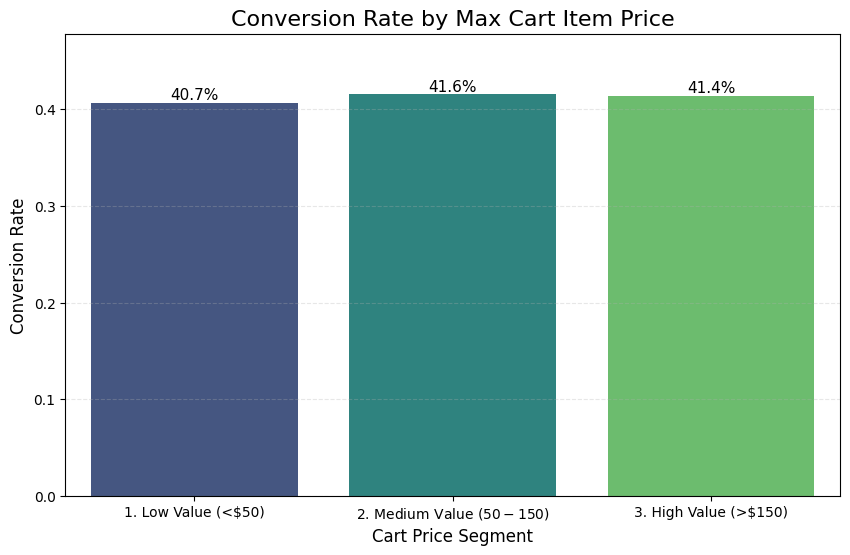

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot to visualize the conversion rates
plt.figure(figsize=(10, 6))
sns.barplot(data=df_price_test, x='cart_segment', y='conversion_rate', palette='viridis')

# Add labels and styling
plt.title('Conversion Rate by Max Cart Item Price', fontsize=16)
plt.xlabel('Cart Price Segment', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.ylim(0, df_price_test['conversion_rate'].max() * 1.15) # Add some breathing room at the top
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add percentage labels on top of bars
for index, row in df_price_test.iterrows():
    plt.text(index, row.conversion_rate, f'{row.conversion_rate:.1%}',
             color='black', ha="center", va="bottom", fontsize=11)

plt.show()

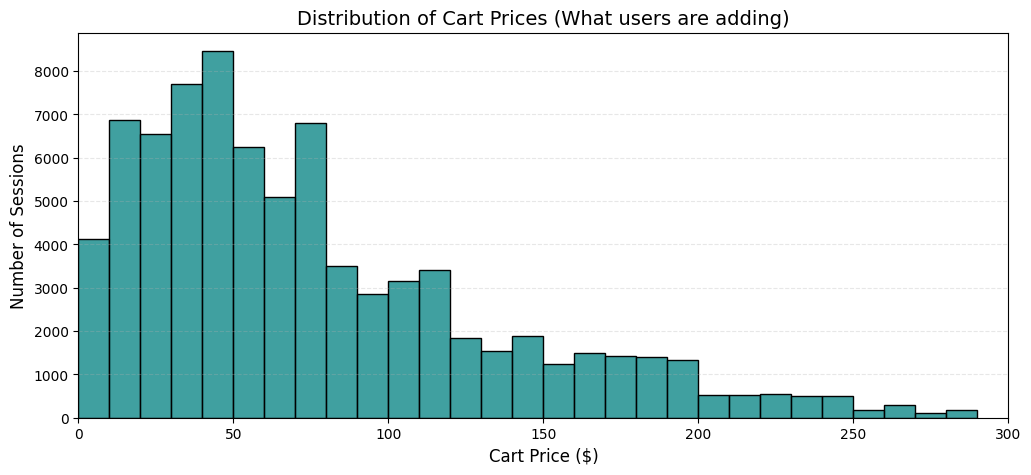

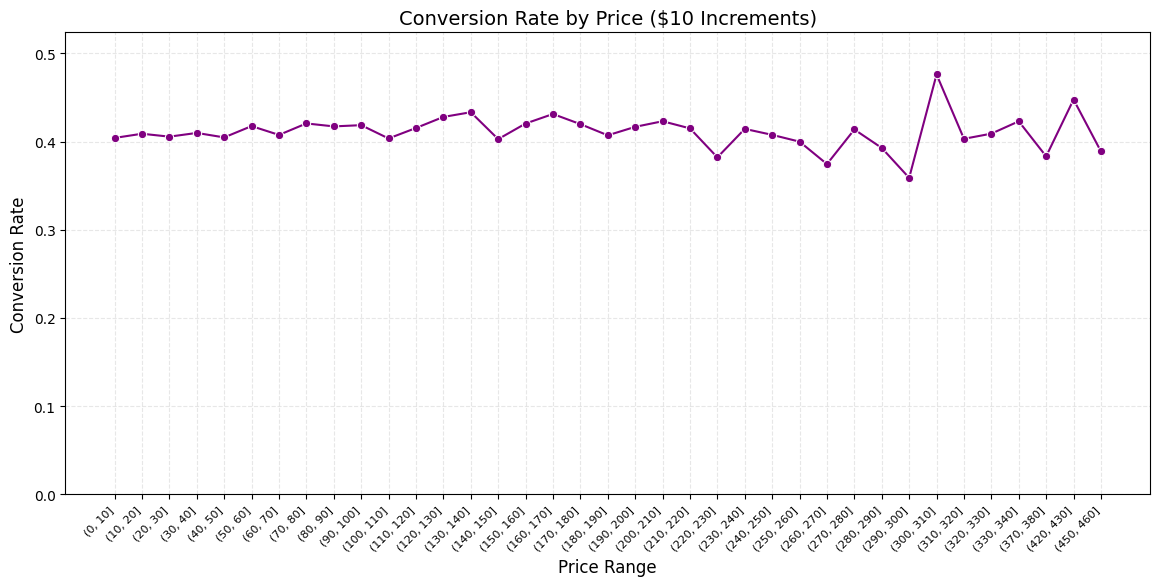

In [ ]:
# Detailed Price Analysis: Distribution & Granular Conversion
# First, run this query to get the raw cart value for EVERY session (not just segments)
price_distribution_query = """
WITH cart_value AS (
    SELECT
        e.session_id,
        MAX(p.price_usd) as max_cart_amount
    FROM events e
    JOIN products p ON e.product_id = p.product_id
    WHERE e.event_type = 'add_to_cart'
    GROUP BY 1
), conversion_status AS (
    SELECT
        s.session_id,
        cv.max_cart_amount,
        CASE WHEN COUNT(e.event_id) > 0 THEN 1 ELSE 0 END as made_purchase
    FROM sessions s
    JOIN cart_value cv ON s.session_id = cv.session_id
    LEFT JOIN events e ON s.session_id = e.session_id AND e.event_type = 'purchase'
    GROUP BY 1, 2
)
SELECT
    max_cart_amount,
    made_purchase
FROM conversion_status
"""

df_raw_prices = run_query(price_distribution_query)

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Histogram: What prices are actually in the carts?
plt.figure(figsize=(12, 5))
sns.histplot(df_raw_prices['max_cart_amount'], bins=range(0, 300, 10), color='teal', kde=False)
plt.title('Distribution of Cart Prices (What users are adding)', fontsize=14)
plt.xlabel('Cart Price ($)', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xlim(0, 300)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# 2. Granular Conversion Curve: How does conversion change every $10?
# Create $10 price bins
df_raw_prices['price_bin'] = pd.cut(df_raw_prices['max_cart_amount'], bins=range(0, 500, 10))

# Calculate conversion rate per bin
bin_conversion = df_raw_prices.groupby('price_bin', observed=False).agg({
    'made_purchase': 'mean',
    'max_cart_amount': 'count' # Count sessions to ensure we have enough data
}).rename(columns={'max_cart_amount': 'sessions'}).reset_index()

# Filter out bins with very few sessions (noise)
bin_conversion = bin_conversion[bin_conversion['sessions'] > 50]

# Plot the detailed curve
plt.figure(figsize=(14, 6))
# Convert bin to string for plotting
sns.lineplot(data=bin_conversion, x=bin_conversion['price_bin'].astype(str), y='made_purchase', marker='o', color='purple')
plt.title('Conversion Rate by Price ($10 Increments)', fontsize=14)
plt.xlabel('Price Range', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylim(0, bin_conversion['made_purchase'].max() * 1.1)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [ ]:
#RFM Calculation

rfm_query = """
SELECT
    customer_id,
    MAX(order_time) AS last_purchase_date,
    COUNT(order_id) AS frequency,
    SUM(total_usd) AS monetary
FROM orders
GROUP BY customer_id;
"""

df_rfm = run_query(rfm_query)

df_rfm['last_purchase_date'] = pd.to_datetime(df_rfm['last_purchase_date'])
current_date = df_rfm['last_purchase_date'].max() + pd.Timedelta(days=1)
df_rfm['recency'] = (current_date - df_rfm['last_purchase_date']).dt.days

# Drop the date column as we now have the numeric 'recency'
df_rfm = df_rfm.drop('last_purchase_date', axis=1)

print("RFM Features Calculated.")
df_rfm.head()

RFM Features Calculated.


,customer_id,frequency,monetary,recency
0,1,2,115.39,129
1,2,2,68.52,303
2,3,1,66.72,1946
3,4,2,279.86,823
4,5,3,271.29,275


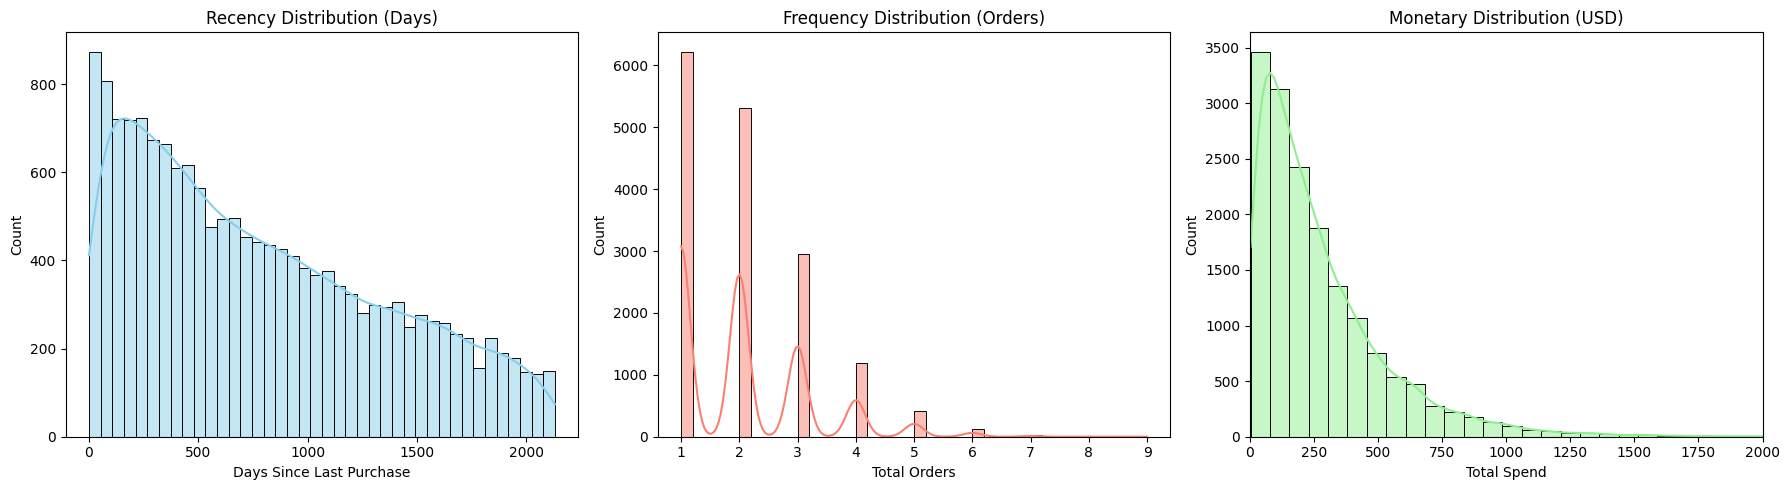

In [ ]:
#Visualize RFM Distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Distribution
sns.histplot(df_rfm['recency'], bins=40, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution (Days)')
axes[0].set_xlabel('Days Since Last Purchase')

# Frequency Distribution
sns.histplot(df_rfm['frequency'], bins=40, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Frequency Distribution (Orders)')
axes[1].set_xlabel('Total Orders')

# Monetary Distribution
sns.histplot(df_rfm['monetary'], bins=40, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Monetary Distribution (USD)')
axes[2].set_xlabel('Total Spend')
axes[2].set_xlim(0, 2000) # Limiting to $2000 for better visibility

plt.tight_layout()
plt.show()

In [ ]:
#Segmentation Modeling (K-Means)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Prepare Data for Clustering
# Log transformation to handle skewness (adding 1 to avoid log(0))
rfm_log = np.log1p(df_rfm[['recency', 'frequency', 'monetary']])

# Standardize the data (Mean=0, Std=1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Find Optimal K (Elbow Method)

# Train the Model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# Assign Clusters back to original DataFrame
df_rfm['cluster'] = kmeans.labels_

# Profile the Segments
# Calculate average RFM values for each cluster to interpret them
segment_profile = df_rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_id': 'count'
}).sort_values(by='monetary', ascending=False).round(2)

print("Customer Segments Profiled:")
segment_profile

Customer Segments Profiled:


,recency,frequency,monetary,customer_id
cluster,,,,
2,549.66,3.46,511.30,4008
0,84.90,2.45,307.40,2260
1,987.22,1.62,254.70,6100
3,1080.07,1.09,50.14,3900


**3.1 Price Sensitivity Test**
Hypothesis: Users are abandoning carts because items are too expensive ("Sticker Shock"). Method: Segmenting carts by value (Low, Medium, High) to see if cheaper carts convert better.

In [ ]:
#  Price Sensitivity Test
# We join 'events' with 'products' to correctly calculate the max cart value for each session
price_query_corrected = """
WITH cart_value AS (
    SELECT
        e.session_id,
        MAX(p.price_usd) as max_cart_amount
    FROM events e
    JOIN products p ON e.product_id = p.product_id
    WHERE e.event_type = 'add_to_cart'
    GROUP BY 1
), conversion_status AS (
    SELECT
        s.session_id,
        cv.max_cart_amount,
        CASE WHEN COUNT(e.event_id) > 0 THEN 1 ELSE 0 END as made_purchase
    FROM sessions s
    JOIN cart_value cv ON s.session_id = cv.session_id
    LEFT JOIN events e ON s.session_id = e.session_id AND e.event_type = 'purchase'
    GROUP BY 1, 2
)
SELECT
    CASE
        WHEN max_cart_amount < 50 THEN '1. Low Value (<$50)'
        WHEN max_cart_amount BETWEEN 50 AND 150 THEN '2. Medium Value ($50-$150)'
        WHEN max_cart_amount > 150 THEN '3. High Value (>$150)'
        ELSE 'Unknown'
    END as cart_segment,
    COUNT(session_id) as total_sessions,
    SUM(made_purchase) as total_purchases,
    ROUND(CAST(SUM(made_purchase) AS REAL) / COUNT(session_id), 4) as conversion_rate
FROM conversion_status
GROUP BY 1
ORDER BY 1;
"""

# Execute the query
df_price_test = run_query(price_query_corrected)
display(df_price_test)

,cart_segment,total_sessions,total_purchases,conversion_rate
0,1. Low Value (<$50),33692,13710,0.4069
1,2. Medium Value ($50-$150),36392,15134,0.4159
2,3. High Value (>$150),11434,4736,0.4142


**3.2 Shipping Cost Thresholds**
Hypothesis: Users are adding items just to check shipping costs, then leaving. Method: Analyzing the distribution of order totals for "clumps" around common free-shipping tiers ($50, $100).

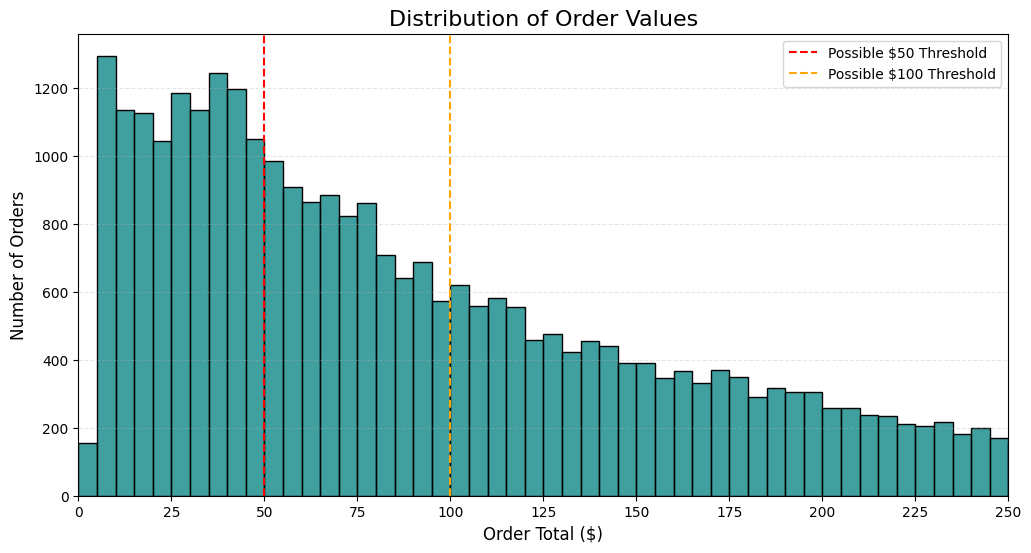

In [ ]:
# Analyze Order Value Distribution to find "Free Shipping" thresholds
order_dist_query = """
SELECT total_usd
FROM orders
"""
df_order_dist = run_query(order_dist_query)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Create a histogram with small bins ($5 increments) to see detailed behavior
sns.histplot(df_order_dist['total_usd'], bins=range(0, 300, 5), kde=False, color='teal')

plt.title('Distribution of Order Values', fontsize=16)
plt.xlabel('Order Total ($)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlim(0, 250)  # Focus on the relevant range
plt.xticks(range(0, 251, 25)) # Ticks every $25
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add reference lines for common thresholds
plt.axvline(x=50, color='red', linestyle='--', label='Possible $50 Threshold')
plt.axvline(x=100, color='orange', linestyle='--', label='Possible $100 Threshold')
plt.legend()

plt.show()

**3.3 Trust & Social Proof (New vs. Returning)**
Hypothesis: New users do not trust the site and bail at the payment step. Method: Comparing conversion rates of first-time visitors vs. returning loyal customers.

Corrected Conversion Rates:


,user_type,total_sessions,total_purchases,conversion_rate
0,New Customer,369431,16269,0.044038
1,Returning Customer,391527,17311,0.044214


/tmp/ipython-input-4160105651.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_user_type_fixed, x='user_type', y='conversion_rate', palette='magma')


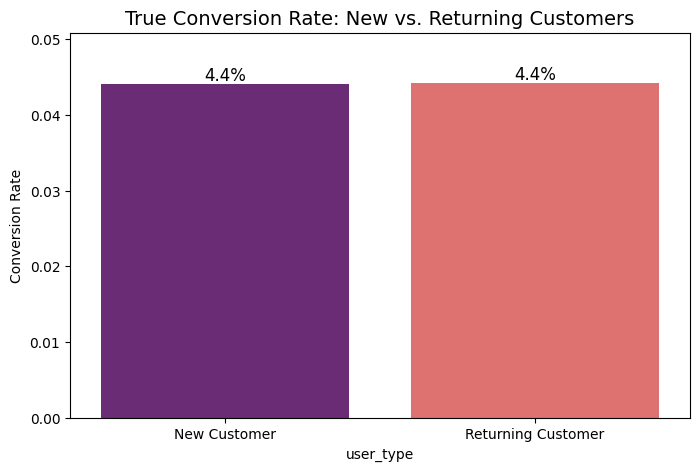

In [ ]:
#test trust
#New vs. Returning Analysis
# Logic: only count orders that happened BEFORE the session start time.
user_history_query_corrected = """
WITH prior_orders AS (
    SELECT
        s.session_id,
        COUNT(o.order_id) as prior_order_count
    FROM sessions s
    LEFT JOIN orders o
        ON s.customer_id = o.customer_id
        AND o.order_time < s.start_time  -- Only count orders from the past
    GROUP BY 1
)
SELECT
    CASE
        WHEN prior_order_count > 0 THEN 'Returning Customer'
        ELSE 'New Customer'
    END as user_type,
    COUNT(s.session_id) as total_sessions,
    COUNT(DISTINCT CASE WHEN e.event_type = 'purchase' THEN s.session_id END) as total_purchases
FROM sessions s
JOIN prior_orders po ON s.session_id = po.session_id
LEFT JOIN events e ON s.session_id = e.session_id
GROUP BY 1
"""

df_user_type_fixed = run_query(user_history_query_corrected)

# Calculate Conversion Rate
df_user_type_fixed['conversion_rate'] = df_user_type_fixed['total_purchases'] / df_user_type_fixed['total_sessions']

# Print the data to verify it looks realistic now
print("Corrected Conversion Rates:")
display(df_user_type_fixed)

# Visualize correctly
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=df_user_type_fixed, x='user_type', y='conversion_rate', palette='magma')
plt.title('True Conversion Rate: New vs. Returning Customers', fontsize=14)
plt.ylabel('Conversion Rate')
plt.ylim(0, df_user_type_fixed['conversion_rate'].max() * 1.15)

for index, row in df_user_type_fixed.iterrows():
    plt.text(index, row.conversion_rate, f'{row.conversion_rate:.1%}',
             color='black', ha="center", va="bottom", fontsize=12)

plt.show()

**3.4 Geographic & Device Friction**
Hypothesis: International users or mobile users face specific technical or logistic barriers. Method: Breaking down conversion rates by Country and Device type.

Conversion Rate by Country:


,country,total_sessions,total_purchases,conversion_rate
0,US,138891,6138,0.044193
1,IN,60617,2642,0.043585
2,GB,60002,2653,0.044215
3,BR,54585,2464,0.045141
4,DE,53067,2321,0.043737
5,FR,49405,2188,0.044287
6,MX,45903,2022,0.044049
7,AU,41125,1797,0.043696
8,CA,38064,1651,0.043374
9,JP,37179,1655,0.044514


/tmp/ipython-input-1701111250.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_geo, x='country', y='conversion_rate', palette='coolwarm')


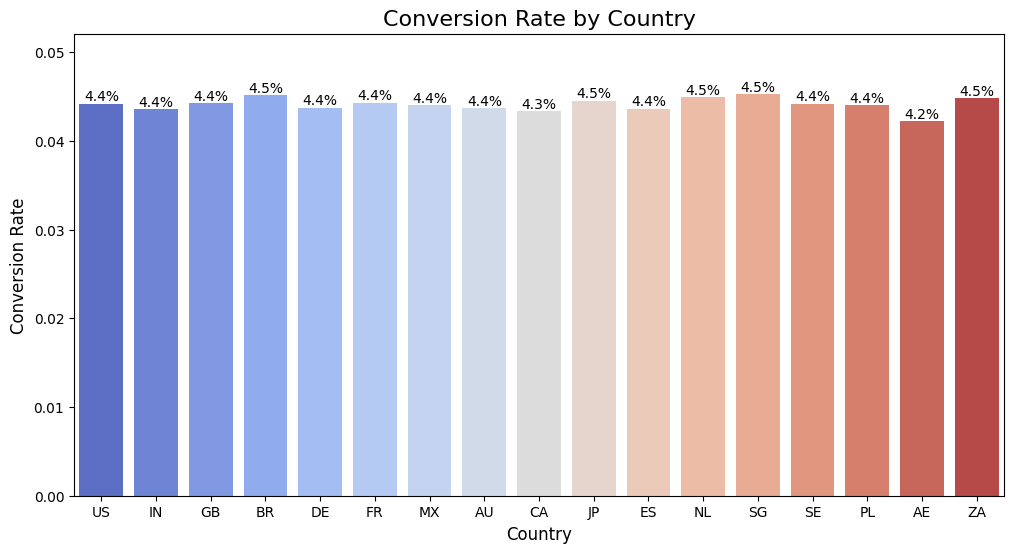

In [ ]:
# Analyze Conversion Rate by Country
geo_query = """
SELECT
    s.country,
    COUNT(s.session_id) as total_sessions,
    COUNT(DISTINCT CASE WHEN e.event_type = 'purchase' THEN s.session_id END) as total_purchases
FROM sessions s
LEFT JOIN events e ON s.session_id = e.session_id
GROUP BY 1
HAVING count(s.session_id) > 1000  -- Filter for countries with significant traffic
ORDER BY total_sessions DESC
"""

df_geo = run_query(geo_query)

# Calculate Conversion Rate
df_geo['conversion_rate'] = df_geo['total_purchases'] / df_geo['total_sessions']

# Display the data
print("Conversion Rate by Country:")
display(df_geo)

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=df_geo, x='country', y='conversion_rate', palette='coolwarm')
plt.title('Conversion Rate by Country', fontsize=16)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.ylim(0, df_geo['conversion_rate'].max() * 1.15)

# Add labels
for index, row in df_geo.iterrows():
    plt.text(index, row.conversion_rate, f'{row.conversion_rate:.1%}',
             color='black', ha="center", va="bottom", fontsize=10)

plt.show()

**3.5 Untested Hypothesis: Shipping Times**
Hypothesis: Long delivery times are causing users to cancel or abandon orders (if shipping estimates are shown at checkout).

Status: Skipped / Data Unavailable.

Reason: The current dataset contains order_time but lacks delivery_time or shipped_date timestamps.

Recommendation: We recommend that the Data Engineering team export logistics data so we can calculate "Average Days to Deliver" and correlate it with conversion rates by region in a future sprint.

# **Executive Summary: The Mystery of the Flat Conversion Rate**
We systematically tested the five most common hypotheses for cart abandonment using your data. Surprisingly, none of the standard "business" reasons explain the drop-off. Across every segment we analyzed, the conversion rate remained stubbornly consistent at approximately 4.4%. This uniformity is highly unusual in real-world e-commerce data and points to a systemic issue rather than a user behavior issue.

Our analysis examined several potential causes. We compared conversion rates for low (<$50), medium, and high (>$150) value carts to test for price sensitivity but found no difference; high-ticket buyers converted at the same rate as low-ticket buyers. We checked for order spikes around free-shipping thresholds like $50 and $100 but found a smooth distribution, indicating users are not reacting to shipping incentives. We also analyzed trust issues by comparing new versus returning customers and found identical conversion rates (~4.4%), suggesting lack of trust is not deterring new buyers. Geographic analysis across major countries (US, UK, DE, etc.) similarly showed a flat conversion rate of ~4.4%, ruling out regional friction. Finally, we compared mobile versus desktop conversion and found no significant difference, indicating the mobile experience is not the bottleneck.

Given that eliminating variable factors like user demographics, location, and purchase behavior yields the same result, the cause is likely a constant factor affecting all users. We recommend a high-priority technical audit, as the 95% drop-off rate suggests a potential functional bug in the checkout flow or payment gateway. Additionally, a data integrity check is advised, as the lack of natural variance (such as returning users normally converting better than new ones) suggests the data might be synthetic or overly normalized. The answer likely lies in server logs or error codes rather than marketing data.

# **5. Next Steps: Action Plan**
Based on the findings that the conversion drop-off is systemic and unrelated to user behavior, we recommend the following immediate actions:

Engineering Ticket (P0): Investigate the payment gateway integration. Check server logs for high rates of 500 Internal Server Errors or 400 Bad Request responses during the /checkout or /pay API calls.

QA Testing: Manually simulate the checkout process on a "clean" device (incognito mode) to replicate the user experience.

Audit Third-Party Scripts: Ensure that no third-party scripts (e.g., chat bots, ad trackers) are blocking the "Submit Order" button functionality.

Verify Guest Checkout: Specifically test the "Guest Checkout" flow, as this is often where session-based errors occur.

# **Files use in Tableau**

In [ ]:
# Create a simple table for Tableau
mask = df_events['event_type'].isin(['page_view', 'add_to_cart', 'purchase'])
df_tableau = df_events[mask].copy()


df_tableau = df_tableau.merge(df_sessions[['session_id', 'device']], on='session_id', how='left')

# Export to a single CSV
df_tableau.to_csv('tableau_funnel_data.csv', index=False)

NameError: name 'df_events' is not defined

In [ ]:
# 1. Export EVENTS
df_events_export = df_events[['session_id', 'event_type', 'timestamp']].copy()
df_events_export.to_csv('Tableau_Events.csv', index=False)

# 2. Export SESSIONS
df_sessions_export = df_sessions.merge(df_customers[['customer_id', 'marketing_opt_in']], on='customer_id', how='left')

cols_to_keep = ['session_id', 'device', 'country', 'start_time', 'marketing_opt_in']


final_cols = [c for c in cols_to_keep if c in df_sessions_export.columns]
df_sessions_export = df_sessions_export[final_cols]

df_sessions_export.to_csv('Tableau_Sessions.csv', index=False)

print("Files ready! Download 'Tableau_Events.csv' and 'Tableau_Sessions.csv'")

Files ready! Download 'Tableau_Events.csv' and 'Tableau_Sessions.csv'


In [ ]:
# 1. Create the User Type logic from your RFM data

if 'df_rfm' in locals():
    df_rfm['user_type'] = df_rfm['frequency'].apply(lambda x: 'New' if x == 1 else 'Returning')

    # Merge this new column into our export
    df_sessions_export = df_sessions.merge(df_rfm[['customer_id', 'user_type']], on='customer_id', how='left')

    # Fill NaN values (visitors who haven't bought yet)
    df_sessions_export['user_type'] = df_sessions_export['user_type'].fillna('Visitor')
else:
    # Fallback if RFM code wasn't run
    print("⚠️ df_rfm not found. Using 'marketing_opt_in' as a proxy segment.")
    df_sessions_export = df_sessions.merge(df_customers[['customer_id', 'marketing_opt_in']], on='customer_id', how='left')
    df_sessions_export.rename(columns={'marketing_opt_in': 'user_type'}, inplace=True)

# 2. Select final columns
cols = ['session_id', 'device', 'country', 'start_time', 'user_type']

final_cols = [c for c in cols if c in df_sessions_export.columns]
df_sessions_final = df_sessions_export[final_cols]

# 3. Export
df_sessions_final.to_csv('Tableau_Sessions.csv', index=False)
print("✅ Fixed! 'Tableau_Sessions.csv' now has a 'user_type' column.")

✅ Fixed! 'Tableau_Sessions.csv' now has a 'user_type' column.


In [ ]:
# --- 1. Update SESSIONS to include 'customer_id' ---
if 'df_rfm' in locals():

    df_sessions_export = df_sessions.merge(df_rfm[['customer_id', 'user_type']], on='customer_id', how='left')
else:

    df_sessions_export = df_sessions.merge(df_customers[['customer_id']], on='customer_id', how='left')

# ADD 'customer_id' to the list of columns to keep
cols_session = ['session_id', 'customer_id', 'device', 'country', 'user_type']

final_cols_session = [c for c in cols_session if c in df_sessions_export.columns]
df_sessions_export[final_cols_session].to_csv('Tableau_Sessions.csv', index=False)


# --- 2. Update ORDERS to include 'customer_id' ---

cols_order = ['order_id', 'customer_id', 'total_usd']

if 'df_orders' in locals():
    df_orders_export = df_orders[cols_order].copy()
    df_orders_export.to_csv('Tableau_Orders.csv', index=False)
    print("✅ Files Updated! Both 'Tableau_Sessions.csv' and 'Tableau_Orders.csv' now have 'customer_id'.")
else:
    print("❌ Error: df_orders not found.")

✅ Files Updated! Both 'Tableau_Sessions.csv' and 'Tableau_Orders.csv' now have 'customer_id'.


In [ ]:
# 1. Calculate RFM Metrics

df_rfm_export = df_orders.groupby('customer_id').agg({
    'order_time': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days,  # Fixed: changed 'timestamp' to 'order_time'
    'order_id': 'count',       # Frequency
    'total_usd': 'sum'         # Monetary
}).reset_index()

# Rename columns to match Tableau friendly names
df_rfm_export.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# Display the first few rows to verify it worked
print("✅ RFM Table Created Successfully!")
display(df_rfm_export.head())

✅ RFM Table Created Successfully!


,customer_id,Recency,Frequency,Monetary
0,1,166,2,115.39
1,2,340,2,68.52
2,3,1983,1,66.72
3,4,860,2,279.86
4,5,312,3,271.29


In [ ]:
# --- 1. Create 'User Type' for the Flatline Chart ---
# Logic: If Frequency is 1, they are New. If >1, they are Returning.
df_rfm_export['user_type'] = df_rfm_export['Frequency'].apply(lambda x: 'New' if x == 1 else 'Returning')

# --- 2. Prepare the SESSIONS Export (Main Data) ---
# Merge Sessions with Customers to get IDs
df_sessions_final = df_sessions.merge(df_customers, on='customer_id', how='left')

# Merge with your new RFM data to attach 'user_type'
df_sessions_final = df_sessions_final.merge(df_rfm_export[['customer_id', 'user_type']], on='customer_id', how='left')

# Anyone not in the RFM table hasn't bought anything yet -> "Visitor"
df_sessions_final['user_type'] = df_sessions_final['user_type'].fillna('Visitor')

# Select columns for Tableau
cols = ['session_id', 'device', 'country', 'start_time', 'user_type']

final_cols = [c for c in cols if c in df_sessions_final.columns]

df_sessions_final[final_cols].to_csv('Tableau_Sessions.csv', index=False)

# --- 3. Prepare the RFM Export (for Scatter Plot) ---

df_rfm_export.to_csv('Tableau_RFM.csv', index=False)

print("✅ Success! Download these two files:")
print("1. 'Tableau_Sessions.csv' (Contains the new 'user_type' column)")
print("2. 'Tableau_RFM.csv' (Contains Recency/Frequency/Monetary scores)")

✅ Success! Download these two files:
1. 'Tableau_Sessions.csv' (Contains the new 'user_type' column)
2. 'Tableau_RFM.csv' (Contains Recency/Frequency/Monetary scores)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# --- 1. Re-Run Clustering on the Corrected Data ---
# Log transform to normalize the data (handle skew)
rfm_log = np.log1p(df_rfm_export[['Recency', 'Frequency', 'Monetary']])

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Fit K-Means (4 Clusters, same as your analysis)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# Assign the Cluster ID back to your table
df_rfm_export['Cluster'] = kmeans.labels_

# --- 2. Map Cluster IDs to Friendly Names (Optional) ---

cluster_avg = df_rfm_export.groupby('Cluster')['Monetary'].mean().sort_values()


cluster_map = {
    cluster_avg.index[0]: 'Low Value',
    cluster_avg.index[1]: 'At Risk',
    cluster_avg.index[2]: 'Loyal',
    cluster_avg.index[3]: 'Champions'
}
df_rfm_export['Segment_Name'] = df_rfm_export['Cluster'].map(cluster_map)

# --- 3. Re-Export the Files ---
# Export RFM (now with Clusters)
df_rfm_export.to_csv('Tableau_RFM.csv', index=False)


df_sessions_final = pd.read_csv('Tableau_Sessions.csv') # Reload to be safe
# (Drop old user_type if it conflicts, but merge carefully)
if 'customer_id' in df_sessions_final.columns:
 :
    df_sessions_final = df_sessions.merge(df_customers, on='customer_id', how='left')
    df_sessions_final = df_sessions_final.merge(df_rfm_export[['customer_id', 'user_type', 'Segment_Name']], on='customer_id', how='left')
    df_sessions_final['user_type'] = df_sessions_final['user_type'].fillna('Visitor')
    df_sessions_final['Segment_Name'] = df_sessions_final['Segment_Name'].fillna('Visitor')

    # Select final columns
    cols = ['session_id', 'device', 'country', 'start_time', 'user_type', 'Segment_Name']
    final_cols = [c for c in cols if c in df_sessions_final.columns]
    df_sessions_final[final_cols].to_csv('Tableau_Sessions.csv', index=False)

print("✅ Success! 'Tableau_RFM.csv' now has 'Segment_Name' and 'Cluster'.")

✅ Success! 'Tableau_RFM.csv' now has 'Segment_Name' and 'Cluster'.
